Imports.

In [13]:
import polars as pl
import numpy as np
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import platform
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from tqdm import tqdm
from mlp import MLP
import random

In [14]:
print(torch.__version__, torch.cuda.is_available(), platform.python_version())
device = "mps" if torch.backends.mps.is_available() else "cpu"

2.7.1 False 3.12.1


Load the dataset.

In [15]:
ds_train = MNIST(root=".", download=True, train=True, transform=ToTensor())

Sanity checks.

shape: (10, 2)
┌───────┬───────┐
│ label ┆ count │
│ ---   ┆ ---   │
│ i64   ┆ u32   │
╞═══════╪═══════╡
│ 0     ┆ 5923  │
│ 1     ┆ 6742  │
│ 2     ┆ 5958  │
│ 3     ┆ 6131  │
│ 4     ┆ 5842  │
│ 5     ┆ 5421  │
│ 6     ┆ 5918  │
│ 7     ┆ 6265  │
│ 8     ┆ 5851  │
│ 9     ┆ 5949  │
└───────┴───────┘


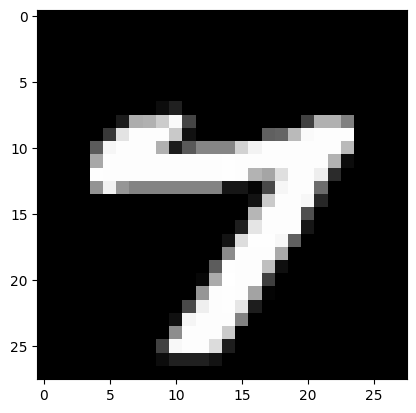

In [16]:
# flatten images / process data
labels = pl.Series(name="label", values=ds_train.targets)
print(labels.value_counts().sort("label"))

random_num = ds_train.data[random.randint(0, len(ds_train))]
plt.imshow(random_num.reshape((28, 28)), cmap="gray")
plt.show()

Define the MLP.

Instantiate training pre-conditions.

In [17]:
EPOCHS = 10
BATCH_SIZE = 128

In [ ]:
train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
model = MLP().to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.05)
loss_fn = nn.CrossEntropyLoss()

Training loop.

In [ ]:
losses = np.zeros((len(train), EPOCHS))
for epoch in tqdm(range(EPOCHS)):
    running_loss = 0.0
    train_iter = iter(train)
    for sample_idx, (imgs, labels) in enumerate(train_iter):
        imgs = imgs.view(-1, 28 * 28).to(device)
        labels = labels.to(device)
        logits = model(imgs)
        loss = loss_fn(logits, labels)
        opt.zero_grad()
        loss.backward()
        opt.step()
        running_loss += loss.item()
        losses[sample_idx, epoch] = loss.item()
    avg = running_loss / len(train)
    print(f"Epoch {epoch+1}/{EPOCHS}  |  loss: {avg:.4f}")

 10%|█         | 1/10 [00:02<00:21,  2.41s/it]

Epoch 1/10  |  loss: 0.9906


 20%|██        | 2/10 [00:04<00:19,  2.40s/it]

Epoch 2/10  |  loss: 0.3514


 30%|███       | 3/10 [00:07<00:16,  2.37s/it]

Epoch 3/10  |  loss: 0.2896


 40%|████      | 4/10 [00:09<00:14,  2.36s/it]

Epoch 4/10  |  loss: 0.2477


 50%|█████     | 5/10 [00:11<00:11,  2.29s/it]

Epoch 5/10  |  loss: 0.2153


 60%|██████    | 6/10 [00:13<00:09,  2.27s/it]

Epoch 6/10  |  loss: 0.1893


 70%|███████   | 7/10 [00:16<00:06,  2.25s/it]

Epoch 7/10  |  loss: 0.1672


 80%|████████  | 8/10 [00:18<00:04,  2.21s/it]

Epoch 8/10  |  loss: 0.1499


 90%|█████████ | 9/10 [00:20<00:02,  2.18s/it]

Epoch 9/10  |  loss: 0.1350


100%|██████████| 10/10 [00:22<00:00,  2.25s/it]

Epoch 10/10  |  loss: 0.1226


Text(0, 0.5, 'Cross-entropy loss')

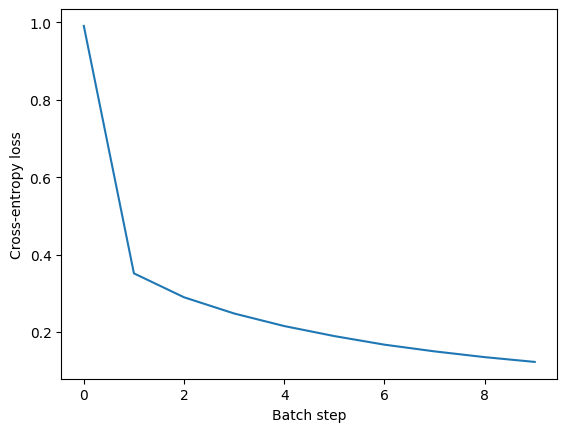

In [ ]:
average_epoch_losses = np.mean(losses, axis=0)
plt.plot(average_epoch_losses)
plt.xlabel("Batch step")
plt.ylabel("Cross-entropy loss")

Evaluation.

In [ ]:
ds_test = MNIST(root=".", download=True, train=False)
model.eval()                                # turn off dropout/BN (habit)

with torch.no_grad():
    imgs = ds_test.data.view(-1, 28*28).float().div_(255).to(device)
    labels = ds_test.targets.to(device)

    logits = model(imgs)
    preds = logits.argmax(dim=1)

    correct = (preds == labels).sum().item()
    total = labels.size(0)

print(f"Accuracy: {correct / total:.2%}")                            # restore training mode

Accuracy: 96.18%
